# CS 179: Final Project
## PCA Recommender System 
---
***Group Members | SID***

Erik Gomez | 38017181 <br>
Filip Velasquez | 47444867 <br>
Killian Weber | 86163603

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import BernoulliRBM

In [2]:
movies = pd.read_csv('ml-latest-small/movies.csv')  # movieId title genres
ratings = pd.read_csv('ml-latest-small/ratings.csv')  # userId movieId rating timestamp
ratings.drop(['timestamp'], axis=1, inplace=True)  # we don't care about timestap so lets get rid of it

In [3]:
# lets further process our data set by merging our tables
data = ratings.merge(movies, on='movieId', how='left')
data.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


We can transform our data into a table where the rows reprsent the userId, and the columns represent the title. 
We can then fill in missing values with 0 to then compute the correlation matrix.

In [4]:
user_title = data.pivot_table(index='userId',columns='title',values='rating')
user_title = user_title.replace(np.nan, 0, regex=True)
user_title.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Let's split into training & test:
# user_title.shape : 610, 9719 (userId, title)
nUsers = user_title.shape[0]
np.random.seed(0)
msk = np.random.rand(len(user_title)) < 0.8

train = user_title[msk]
test = user_title[~msk]

percent_masked = .3 # The percentage of data that is missing and needs to be estimated.
masked_test = np.copy(test)
masked_test[ np.random.random_sample(masked_test.shape)<=percent_masked ] = -1

We want to standardize our data so that the mean of observed values is 0 and the standard deviation is 1. We will do this using scikit-learn object StandardScalar. 

In [6]:
# converts to a range between 0 and 1
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train)

With our standardized data, we can create a covariance matrix that represents the covariance between each feature in our data.

In [7]:
cov_matrix = np.cov(scaled_train)

We can then take the eigen decomposition of the covariance matrix to get the principal components.

In [8]:
eigen_values, eigen_vectors = np.linalg.eig(cov_matrix)

Plotting the explained variance and cumulative explained variance can help determine K.

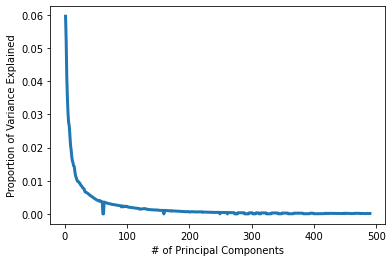

In [9]:
var_explained = []

for i in eigen_values:
    var_explained.append((i/sum(eigen_values)))


plt.plot(range(1,491), var_explained, lw=3)
plt.ylabel('Proportion of Variance Explained')
plt.xlabel('# of Principal Components')

plt.show()

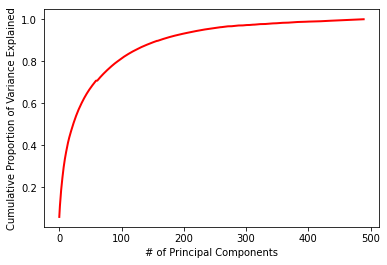

In [10]:
cum_var_explained = np.cumsum(var_explained)

plt.plot(range(490), cum_var_explained, 'r-', lw=2)
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.xlabel('# of Principal Components')

plt.show()

Apply the K components to the original standardized data where K is the number of components chosen. We chose K = 200 because it explains about 90% of the variance in the data set.

In [11]:
from scipy.linalg import svd

U, s, V = np.linalg.svd(scaled_train, full_matrices=False)

In [12]:
W = U.dot(np.diag(s))

In [13]:
X0 = W[:,:200].dot(V[:200])

In [14]:
X = scaler.inverse_transform(X0)
X

array([[ 1.39912222e-04,  7.46244764e-04, -4.17657648e-04, ...,
        -3.69322047e-04,  3.97667790e+00,  6.31904536e-05],
       [-3.97055363e-03, -1.39478956e-02, -1.34089762e-02, ...,
        -6.04741652e-04, -5.24060610e-02, -1.02790275e-04],
       [ 1.08908155e-04,  3.29420350e-04,  2.80993384e-04, ...,
        -5.11931623e-04,  1.04639134e-02, -7.45221570e-05],
       ...,
       [ 5.89896623e-05, -1.64974975e-03, -6.80425374e-04, ...,
        -4.17598027e-04,  3.25070816e-03,  8.46480469e-05],
       [-1.51057359e-03,  8.79620878e-03,  4.72737228e-03, ...,
        -3.89653946e-03, -1.70138960e-01,  1.06543575e-03],
       [ 3.99973401e+00,  3.30170747e-04,  3.43606079e-04, ...,
         1.50001496e+00,  7.20660030e-04,  2.68145467e-06]])

In [15]:
user_ratings = user_title.to_numpy()

RBM_data = (user_ratings >= 4).astype(int)

num_users,num_movies = RBM_data.shape

cut = int(num_users*.7)
Xtr = RBM_data[:cut,::]
Xte = RBM_data[cut:,::]


percent_masked = .3 # The percentage of data that is missing and needs to be estimated.
Xte_mis = np.copy(Xte)
Xte_mis[ np.random.random_sample(Xte_mis.shape)<=percent_masked ] = -1

In [ ]:
RBM = BernoulliRBM(n_components=16, learning_rate=0.1, batch_size=10, n_iter=100, verbose=0, random_state=0)

In [ ]:
RBM.fit(Xtr)

In [ ]:
print(RBM.score_samples(Xte).mean())

In [ ]:
Xte_mis_c = np.copy(Xte_mis)
Xte_mis_c[Xte_mis_c<0] = 0.5
for it in range(100):
    Xte_mis_c=RBM.gibbs(Xte_mis_c)
    Xte_mis_c[Xte_mis >= 0] = Xte_mis[Xte_mis >= 0]


count = 0
for i in range(Xte_mis_c.shape[0]):
    for j in range(Xte_mis_c.shape[1]):
        if Xte_mis_c[i,j] != Xte[i,j]:
            count += 1
print(count/(Xte_mis_c.shape[0] * Xte_mis_c.shape[1]))
print('Error rate:', np.mean( (Xte_mis_c!=Xte)[Xte_mis<0] ) )

In [16]:
simple_learn_rate = [.001, .01, .1]
learnrate = [.001, .005, .01, .015, .02, .025, .03, .035, .04, .045, .05, .055, .06, .065, .07, .075, .08, .085, .09, .095, .1]
components = [16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256, 272, 288, 304, 320, 336, 352, 368, 384, 400, 416, 432, 448, 464, 480, 496, 512]

In [ ]:
error_rates = []
for c in components:
    RBM = BernoulliRBM(n_components=c, learning_rate=0.1, batch_size=10, n_iter=100, verbose=0, random_state=0)
    RBM.fit(Xtr)
    Xte_mis_c = np.copy(Xte_mis)
    Xte_mis_c[Xte_mis_c<0] = 0.5
    for it in range(100):
        Xte_mis_c=RBM.gibbs(Xte_mis_c)
        Xte_mis_c[Xte_mis >= 0] = Xte_mis[Xte_mis >= 0]
    
    count = 0
    for i in range(Xte_mis_c.shape[0]):
        for j in range(Xte_mis_c.shape[1]):
            if Xte_mis_c[i,j] != Xte[i,j]:
                count += 1
    print(np.mean( (Xte_mis_c!=Xte)[Xte_mis<0]), ": #Components", c)
    error_rates.append( np.mean( (Xte_mis_c!=Xte)[Xte_mis<0]) )

In [ ]:
plt.plot(components, error_rates, 'r-', lw=2)
plt.ylabel('Error Rate')
plt.xlabel('# of Components in the Model')

plt.show()

In [17]:
# DON'T RERUN UNLESS YOU WANT TO BE HERE ALL DAY
all_models = []
for l in simple_learn_rate:
    models = []
    for c in components:
        RBM = BernoulliRBM(n_components=c, learning_rate=l, batch_size=10, n_iter=100, verbose=0, random_state=0)
        RBM.fit(Xtr)
        models.append(RBM)
    all_models.append(models)
    print("Finished: ", l)

Finished:  0.001
Finished:  0.01
Finished:  0.1


In [18]:
cpyAll = all_models.copy()

In [20]:
all_results = []
for i in all_models:
    results = []
    for j in i:
        Xte_mis_c = np.copy(Xte_mis)
        Xte_mis_c[Xte_mis_c<0] = 0.5
        for it in range(100):
            Xte_mis_c=j.gibbs(Xte_mis_c)
            Xte_mis_c[Xte_mis >= 0] = Xte_mis[Xte_mis >= 0]
            print()
        print(np.mean( (Xte_mis_c!=Xte)[Xte_mis<0]), ": #Components", c)
        results.append( np.mean( (Xte_mis_c!=Xte)[Xte_mis<0]) )
    all_results.append(results)

0.145075479610022 : #Components 512
0.08159360819492908 : #Components 512
0.09697407634822458 : #Components 512
0.08489022509097989 : #Components 512
0.08097022748715799 : #Components 512
0.0453233342818205 : #Components 512
0.07377046111452233 : #Components 512
0.07285130217303401 : #Components 512
0.044003564314917705 : #Components 512
0.043462552229194436 : #Components 512
0.06520412442154763 : #Components 512
0.05429028200020967 : #Components 512
0.04712046785377323 : #Components 512
0.047051203330687554 : #Components 512
0.046691776616297004 : #Components 512
0.03564689320533749 : #Components 512
0.04087730070537493 : #Components 512
0.03641254698755485 : #Components 512
0.03716696868494751 : #Components 512
0.027260269869558054 : #Components 512
0.03304104952600602 : #Components 512
0.032646054543003906 : #Components 512
0.03292311263534662 : #Components 512
0.03257117397750588 : #Components 512
0.04122549533494077 : #Components 512
0.03223233941862729 : #Components 512
0.0263972

In [21]:
colors = ['b-','g-','r-']

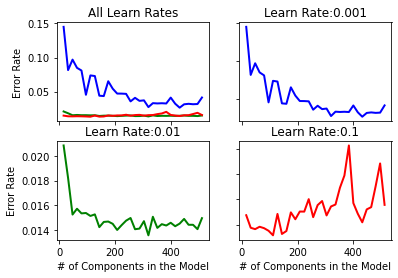

In [27]:
fig, axs = plt.subplots(2, 2)

for i in range(len(simple_learn_rate)):
    axs[0,0].plot(components, all_results[i], colors[i], lw=2, label =("Learn Rate:" + str(simple_learn_rate[i])))
axs[0, 0].set_title('All Learn Rates')

axs[0,1].plot(components, all_results[0], colors[0], lw=2, label =("Learn Rate:" + str(simple_learn_rate[0])))
axs[0, 1].set_title("Learn Rate:" + str(simple_learn_rate[0]))

axs[1,0].plot(components, all_results[1], colors[1], lw=2, label =("Learn Rate:" + str(simple_learn_rate[1])))
axs[1, 0].set_title("Learn Rate:" + str(simple_learn_rate[1]))

axs[1,1].plot(components, all_results[2], colors[2], lw=2, label =("Learn Rate:" + str(simple_learn_rate[2])))
axs[1, 1].set_title("Learn Rate:" + str(simple_learn_rate[2]))

for ax in axs.flat:
    ax.set(xlabel='# of Components in the Model', ylabel='Error Rate')

for ax in axs.flat:
    ax.label_outer()

In [28]:
all_scores = []
for i in all_models:
    scores = []
    for j in i:
        scores.append(j.score_samples(Xte).mean())
    all_scores.append(scores)

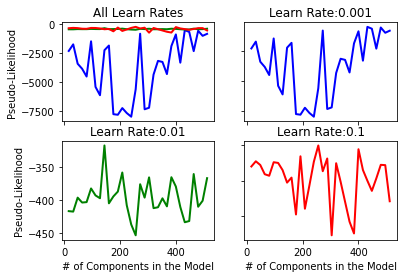

In [32]:
fig, axs = plt.subplots(2, 2)

for i in range(len(simple_learn_rate)):
    axs[0,0].plot(components, all_scores[i], colors[i], lw=2, label =("Learn Rate:" + str(simple_learn_rate[i])))
axs[0, 0].set_title('All Learn Rates')

axs[0,1].plot(components, all_scores[0], colors[0], lw=2, label =("Learn Rate:" + str(simple_learn_rate[0])))
axs[0, 1].set_title("Learn Rate:" + str(simple_learn_rate[0]))

axs[1,0].plot(components, all_scores[1], colors[1], lw=2, label =("Learn Rate:" + str(simple_learn_rate[1])))
axs[1, 0].set_title("Learn Rate:" + str(simple_learn_rate[1]))

axs[1,1].plot(components, all_scores[2], colors[2], lw=2, label =("Learn Rate:" + str(simple_learn_rate[2])))
axs[1, 1].set_title("Learn Rate:" + str(simple_learn_rate[2]))

for ax in axs.flat:
    ax.set(xlabel='# of Components in the Model', ylabel='Pseudo-Likelihood')

for ax in axs.flat:
    ax.label_outer()

In [38]:
from sklearn.metrics import mean_squared_error
all_mse = []
for i in all_models:
    mse = []
    for j in i:
        Xte_mis_c = np.copy(Xte_mis)
        Xte_mis_c[Xte_mis_c<0] = 0.5
        for it in range(100):
            Xte_mis_c=j.gibbs(Xte_mis_c)
            Xte_mis_c[Xte_mis >= 0] = Xte_mis[Xte_mis >= 0]
        mse.append(mean_squared_error(Xte_mis_c, Xte))
    all_mse.append(mse)

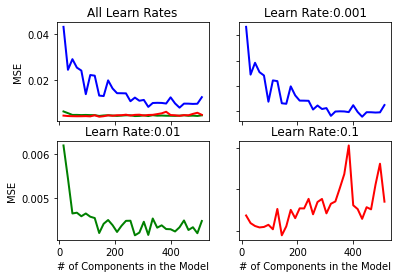

In [39]:
fig, axs = plt.subplots(2, 2)

for i in range(len(simple_learn_rate)):
    axs[0,0].plot(components, all_mse[i], colors[i], lw=2, label =("Learn Rate:" + str(simple_learn_rate[i])))
axs[0, 0].set_title('All Learn Rates')

axs[0,1].plot(components, all_mse[0], colors[0], lw=2, label =("Learn Rate:" + str(simple_learn_rate[0])))
axs[0, 1].set_title("Learn Rate:" + str(simple_learn_rate[0]))

axs[1,0].plot(components, all_mse[1], colors[1], lw=2, label =("Learn Rate:" + str(simple_learn_rate[1])))
axs[1, 0].set_title("Learn Rate:" + str(simple_learn_rate[1]))

axs[1,1].plot(components, all_mse[2], colors[2], lw=2, label =("Learn Rate:" + str(simple_learn_rate[2])))
axs[1, 1].set_title("Learn Rate:" + str(simple_learn_rate[2]))

for ax in axs.flat:
    ax.set(xlabel='# of Components in the Model', ylabel='MSE')

for ax in axs.flat:
    ax.label_outer()